## Importing the Libraries


In [1]:
!pip install contractions
!pip install nltk


# Standard library imports
import string
import re

import contractions
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from numpy import *
import seaborn as sns
from gensim.models import Word2Vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from wordcloud import WordCloud, STOPWORDS


# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 11.6 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Read in the Data

In [2]:
unclean_df = pd.read_csv("stock_data_text.csv")

## Analysing the Data

In [3]:
unclean_df.head(10)

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
5,PGNX Over 3.04,1
6,AAP - user if so then the current downtrend wi...,-1
7,Monday's relative weakness. NYX WIN TIE TAP IC...,-1
8,GOOG - ower trend line channel test & volume s...,1
9,AAP will watch tomorrow for ONG entry.,1


In [4]:
unclean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


In [5]:
unclean_df.describe()

,Sentiment
count,5791.000000
mean,0.272664
std,0.962192
min,-1.000000
25%,-1.000000
50%,1.000000
75%,1.000000
max,1.000000


## Exploratory Data Analysis


Check for missing values

In [6]:
unclean_df.isna().sum().to_frame(name='Number of missing values')

,Number of missing values
Text,0
Sentiment,0


Check for and remove duplicate rows

In [7]:
before =  unclean_df.shape[0]
unclean_df.drop_duplicates(inplace=True)
after = unclean_df.shape[0]

print("No. of rows removed :", before - after)

No. of rows removed : 0


Remove HTML Syntaxes

In [8]:
def remove_html(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    return data

In [9]:
unclean_df['Cleaned_Text'] = unclean_df['Text'].apply(lambda z: remove_html(z))


Remove URL Data

In [10]:
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data



In [11]:
unclean_df['Cleaned_Text'] = unclean_df['Text'].apply(lambda z: remove_url(z))


Remove Emojis

In [12]:
def remove_emoji(data):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data



In [13]:
unclean_df['Cleaned_Text'] = unclean_df['Text'].apply(lambda z: remove_emoji(z))


Lower Case

In [14]:
ticker_df = pd.read_csv('ticker_list1.csv')
ticker_df = ticker_df['Symbol']
ticker_df.head()

0        A
1       AA
2     AACG
3     AACI
4    AACIU
Name: Symbol, dtype: object

In [15]:
ticker_df2 = pd.read_csv('ticker_list2.csv')
ticker_df2 = ticker_df2['Symbol']
ticker_df2.head()

0        A
1       AA
2     AACG
3     AACI
4    AACIW
Name: Symbol, dtype: object

In [16]:
#Merge 2 series and convert it to a list
ticker_list1 = ticker_df.tolist()
ticker_list2 = ticker_df2.tolist()
all_tickers = list(set(ticker_list1 + ticker_list2))

In [17]:
unclean_df.head()

,Text,Sentiment,Cleaned_Text
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user: AAP MOVIE. 55% return for the FEA/GEED i...
2,user I'd be afraid to short AMZN - they are lo...,1,user I'd be afraid to short AMZN - they are lo...
3,MNTA Over 12.00,1,MNTA Over 12.00
4,OI Over 21.37,1,OI Over 21.37


In [18]:
def lowercase(text):
  word_list = str(text).split(' ')
  return ' '.join([word.lower() if word not in all_tickers else word for word in word_list])

unclean_df['Cleaned_Text'] = unclean_df['Cleaned_Text'].apply(lowercase)

In [19]:
unclean_df.head(20)

,Text,Sentiment,Cleaned_Text
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,kickers on my watchlist xide tit soq pnk cpw b...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user: AAP movie. 55% return for the fea/geed i...
2,user I'd be afraid to short AMZN - they are lo...,1,user i'd be afraid to short AMZN - they are lo...
3,MNTA Over 12.00,1,mnta over 12.00
4,OI Over 21.37,1,OI over 21.37
5,PGNX Over 3.04,1,pgnx over 3.04
6,AAP - user if so then the current downtrend wi...,-1,AAP - user if so then the current downtrend wi...
7,Monday's relative weakness. NYX WIN TIE TAP IC...,-1,monday's relative weakness. nyx win tie TAP IC...
8,GOOG - ower trend line channel test & volume s...,1,GOOG - ower trend line channel test & volume s...
9,AAP will watch tomorrow for ONG entry.,1,AAP will watch tomorrow for ong entry.


Remove Contractions

In [20]:
unclean_df['Cleaned_Text'] = unclean_df['Cleaned_Text'].apply(contractions.fix)


In [21]:
unclean_df.head()


,Text,Sentiment,Cleaned_Text
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,kickers on my watchlist xide tit soq pnk cpw b...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user: AAP movie. 55% return for the fea/geed i...
2,user I'd be afraid to short AMZN - they are lo...,1,user i would be afraid to short AMZN - they ar...
3,MNTA Over 12.00,1,mnta over 12.00
4,OI Over 21.37,1,OI over 21.37


Remove all punctuations



In [22]:
def remove_punctuation(text):
  return "".join([char for char in text if char not in string.punctuation])


unclean_df['Cleaned_Text'] = unclean_df['Cleaned_Text'].apply(remove_punctuation)

In [23]:
unclean_df.head()

,Text,Sentiment,Cleaned_Text
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,kickers on my watchlist xide tit soq pnk cpw b...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP movie 55 return for the feageed indic...
2,user I'd be afraid to short AMZN - they are lo...,1,user i would be afraid to short AMZN they are...
3,MNTA Over 12.00,1,mnta over 1200
4,OI Over 21.37,1,OI over 2137


Data has been cleaned, now we make a copy of it in a variable cleaned dataframe

In [24]:
cleaned_df = unclean_df

Tokenisation

In [25]:
tokenizer = TweetTokenizer()
cleaned_df['Cleaned_Text'] = cleaned_df['Cleaned_Text'].apply(tokenizer.tokenize)

Remove Stopwords

In [26]:
stop_words = set(stopwords.words('english'))


In [27]:
#Keep these words in the text as they could correlate to sentiment
keep_in_tokens = ["no","not", "on", "off", "too", "out", "over", "under"]

for word in keep_in_tokens:
    stop_words.remove(word)
def filter_tokens(tokens):
    return [token for token in tokens if token not in stop_words]
cleaned_df["Cleaned_Text"] = cleaned_df["Cleaned_Text"].apply(filter_tokens)


Lemmatisation


In [28]:
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(filtered_tokens):
  return ' '.join([lemmatizer.lemmatize(token) for token in filtered_tokens])

cleaned_df['Cleaned_Text'] = cleaned_df['Cleaned_Text'].apply(lemmatize_tokens)


### Comparing unprocessed vs processed text

In [29]:
cleaned_df.head(10)

,Text,Sentiment,Cleaned_Text
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,kicker on watchlist xide tit soq pnk cpw bpz a...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP movie 55 return feageed indicator 15 ...
2,user I'd be afraid to short AMZN - they are lo...,1,user would afraid short AMZN looking like near...
3,MNTA Over 12.00,1,mnta over 1200
4,OI Over 21.37,1,OI over 2137
5,PGNX Over 3.04,1,pgnx over 304
6,AAP - user if so then the current downtrend wi...,-1,AAP user current downtrend break otherwise sho...
7,Monday's relative weakness. NYX WIN TIE TAP IC...,-1,monday relative weakness nyx win tie TAP ICE i...
8,GOOG - ower trend line channel test & volume s...,1,GOOG ower trend line channel test volume support
9,AAP will watch tomorrow for ONG entry.,1,AAP watch tomorrow ong entry


In [30]:
#Re-setting the cleaned_df to only a column with the cleaned text
temp_df = cleaned_df[['Cleaned_Text', 'Sentiment']].copy()
temp_df.rename(columns = {'Cleaned_Text': 'Text'}, inplace=True)
temp_df.head()

,Text,Sentiment
0,kicker on watchlist xide tit soq pnk cpw bpz a...,1
1,user AAP movie 55 return feageed indicator 15 ...,1
2,user would afraid short AMZN looking like near...,1
3,mnta over 1200,1
4,OI over 2137,1


In [31]:
cleaned_df = temp_df

## Word Cloud

In [32]:
def generate_wcloud(text):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(stopwords=stopwords, background_color='white')
    wordcloud.generate(text)

    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

Semantic 1 word cloud

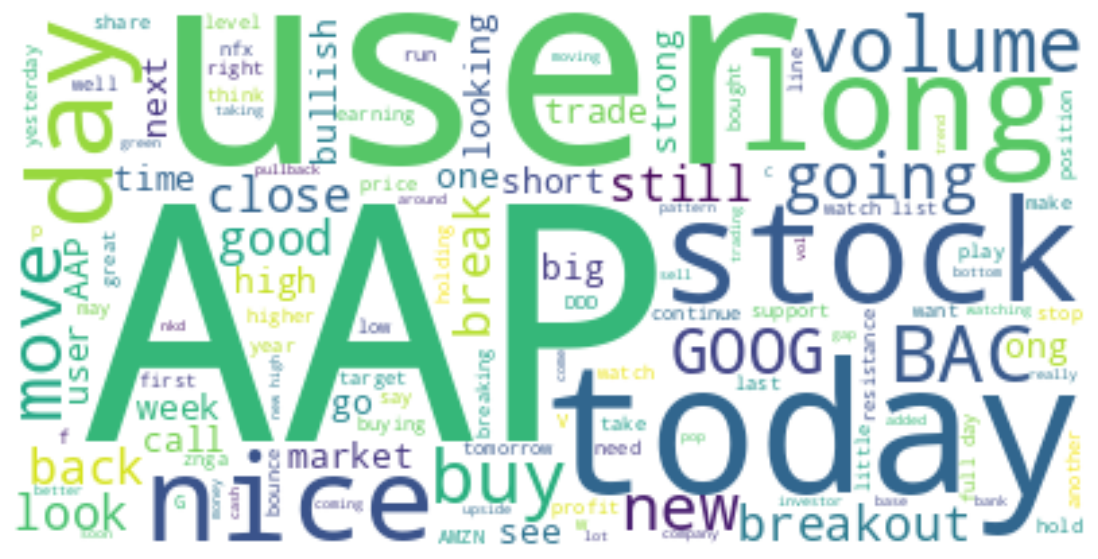

In [33]:
pos = cleaned_df.loc[cleaned_df['Sentiment'] == 1].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

Semantic -1 word cloud

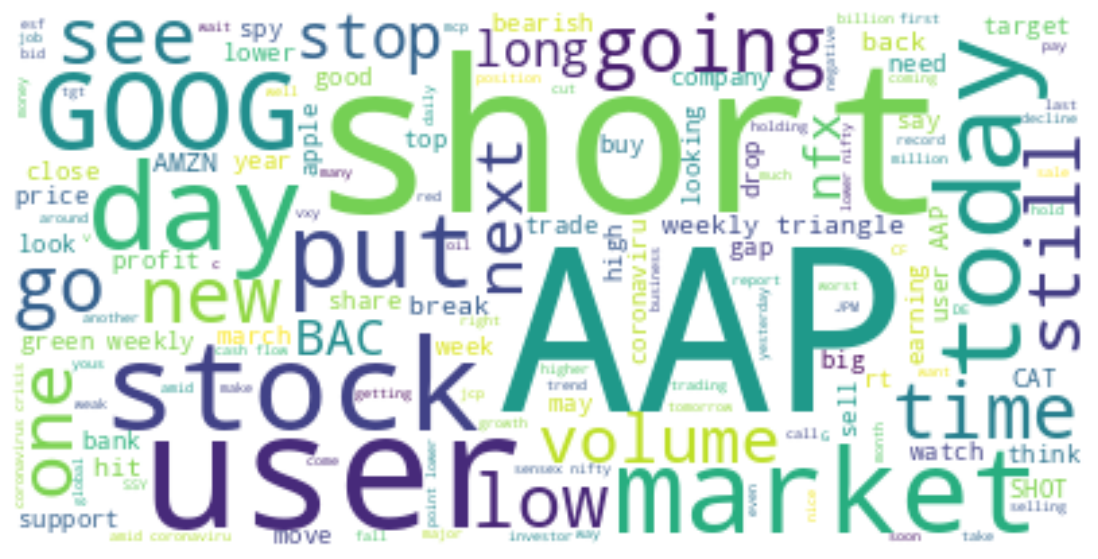

In [34]:
pos = cleaned_df.loc[cleaned_df['Sentiment'] == -1].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

## Train Test Split

Train data: 80%
Test data: 20%

In [35]:
X = cleaned_df['Text']
y = cleaned_df['Sentiment']

#Generate Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [36]:
X_train.shape, X_test.shape

((4632,), (1159,))

In [37]:
y_train.shape, y_test.shape

((4632,), (1159,))

## Vectorisation

Bag of Words Vectorizer

In [38]:
# Create a bag-of-words representation of the data
bow_vectorizer = CountVectorizer()
bow_vectorizer.fit(X_train)

# Transform
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)

TF_IDF Vectorizer

In [39]:
# Create a term frequency representation of the data
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)

# Transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

## Testing out different Models  

In [40]:
from sklearn.metrics import accuracy_score

#Create standardised function to train and evaluate a particular model
def train_and_eval(model, trainX, trainY, testX, testY):

    # training the model
    fitted_model = model.fit(trainX, trainY)

    # getting predictions
    y_preds_train = fitted_model.predict(trainX)
    y_preds_test = fitted_model.predict(testX)

    # evaluating the model
    print()
    print(model)
    print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
    print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")
    print('\n',40*'-')

Logistic Regression with BoW Vectorizer

In [41]:
C = [0.001, 0.01, 0.1, 1, 10]

for c in C:
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500)

    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500)
Train accuracy score : 0.6381692573402418
Test accuracy score : 0.6289905090595341

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500)
Train accuracy score : 0.6953799654576857
Test accuracy score : 0.6876617773943055

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500)
Train accuracy score : 0.832685664939551
Test accuracy score : 0.7679033649698016

 ----------------------------------------

LogisticRegression(C=1, max_iter=500)
Train accuracy score : 0.9620034542314335
Test accuracy score : 0.8015530629853321

 ----------------------------------------

LogisticRegression(C=10, max_iter=500)
Train accuracy score : 0.9974093264248705
Test accuracy score : 0.7972389991371872

 ----------------------------------------


Naive Bayes Classifier with BoW Vectorizer

In [42]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas:
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.9624352331606217
Test accuracy score : 0.7238999137187231

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.9473229706390328
Test accuracy score : 0.7532355478861087

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.9285405872193437
Test accuracy score : 0.7610008628127696

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.9216321243523317
Test accuracy score : 0.7610008628127696

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.9127806563039723
Test accuracy score : 0.7627264883520276

 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


Random Forest Classifier with BoW Vectorizer

In [43]:
trees = [50,100,150,200]

for t in trees:
  RandFor = RandomForestClassifier(n_estimators = t)
  train_and_eval(model=RandFor,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


RandomForestClassifier(n_estimators=50)
Train accuracy score : 0.9997841105354058
Test accuracy score : 0.7920621225194133

 ----------------------------------------

RandomForestClassifier()
Train accuracy score : 0.9997841105354058
Test accuracy score : 0.7963761863675582

 ----------------------------------------

RandomForestClassifier(n_estimators=150)
Train accuracy score : 0.9997841105354058
Test accuracy score : 0.7911993097497843

 ----------------------------------------

RandomForestClassifier(n_estimators=200)
Train accuracy score : 0.9997841105354058
Test accuracy score : 0.7911993097497843

 ----------------------------------------


Logistic Regression with TFIDF Vectorizer

In [44]:
C = [0.001, 0.01, 0.1, 1, 10,]

for c in C:
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500)

    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500)
Train accuracy score : 0.6381692573402418
Test accuracy score : 0.6289905090595341

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500)
Train accuracy score : 0.6381692573402418
Test accuracy score : 0.6289905090595341

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500)
Train accuracy score : 0.6692573402417962
Test accuracy score : 0.6652286453839517

 ----------------------------------------

LogisticRegression(C=1, max_iter=500)
Train accuracy score : 0.8646373056994818
Test accuracy score : 0.7765314926660914

 ----------------------------------------

LogisticRegression(C=10, max_iter=500)
Train accuracy score : 0.9879101899827288
Test accuracy score : 0.8015530629853321

 ----------------------------------------


Naive Bayes Classifier with TFIDF Vectorizer

In [45]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas:
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.9667530224525043
Test accuracy score : 0.7169974115616912

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.9425734024179621
Test accuracy score : 0.7540983606557377

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.8905440414507773
Test accuracy score : 0.7411561691113029

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.8715457685664939
Test accuracy score : 0.7359792924935289

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.8469343696027634
Test accuracy score : 0.72648835202761

 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


Random Forest Classifier with TFIDF Vectorizer

In [46]:
trees = [50,100,150,200]

for t in trees:
  RandFor = RandomForestClassifier(n_estimators = t)
  train_and_eval(model=RandFor,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


RandomForestClassifier(n_estimators=50)
Train accuracy score : 0.9997841105354058
Test accuracy score : 0.7834339948231234

 ----------------------------------------

RandomForestClassifier()
Train accuracy score : 0.9997841105354058
Test accuracy score : 0.7842968075927523

 ----------------------------------------

RandomForestClassifier(n_estimators=150)
Train accuracy score : 0.9997841105354058
Test accuracy score : 0.7886108714408974

 ----------------------------------------

RandomForestClassifier(n_estimators=200)
Train accuracy score : 0.9997841105354058
Test accuracy score : 0.7877480586712683

 ----------------------------------------


## Best Model

In [48]:
log_model = LogisticRegression(C=1, max_iter=500)

    # Train and evaluate model
train_and_eval(model=log_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


LogisticRegression(C=1, max_iter=500)
Train accuracy score : 0.9620034542314335
Test accuracy score : 0.8015530629853321

 ----------------------------------------


The Logistic Regression model trained on BoW data with parameters C=1 delivers the best accuracy of 80.1% on test data